In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import h5py


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

2024-05-14 22:22:03.054350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 22:22:11.043108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jhuang/miniconda3/envs/venv/lib:/home/jhuang/miniconda3/envs/venv/nvvm/libdevice:/home/jhuang/miniconda3/envs/venv/lib:/home/jhuang/miniconda3/envs/venv/nvvm/libdevice::/home/jhuang/miniconda3/envs/venv/lib/
2024-05-14 22:22:11.043239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

GPU Detected: GPU - /physical_device:GPU:0
GPU Detected: GPU - /physical_device:GPU:1


# Data acquisition

In [2]:
# Read data form csv
df = pd.read_csv("./FERPlus-master/fer2013new.csv")
df

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35882,PrivateTest,fer0035797.png,8,0,0,2,0,0,0,0,0,0
35883,PrivateTest,NaN,0,0,0,0,0,0,0,0,0,10
35884,PrivateTest,fer0035799.png,0,0,0,0,7,1,0,2,0,0
35885,PrivateTest,fer0035800.png,0,10,0,0,0,0,0,0,0,0


In [3]:
# Display its general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Usage       35887 non-null  object
 1   Image name  35714 non-null  object
 2   neutral     35887 non-null  int64 
 3   happiness   35887 non-null  int64 
 4   surprise    35887 non-null  int64 
 5   sadness     35887 non-null  int64 
 6   anger       35887 non-null  int64 
 7   disgust     35887 non-null  int64 
 8   fear        35887 non-null  int64 
 9   contempt    35887 non-null  int64 
 10  unknown     35887 non-null  int64 
 11  NF          35887 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.3+ MB


# Preprocessing

In [4]:
# Check for any missing data particularly in 'Image name' column
missing_data = df.isnull().sum()
missing_data

Usage           0
Image name    173
neutral         0
happiness       0
surprise        0
sadness         0
anger           0
disgust         0
fear            0
contempt        0
unknown         0
NF              0
dtype: int64

In [5]:
# Remove entries with missing 'Image name'
clean_df = df.dropna(subset=['Image name'])

# Confirm the removal
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35714 entries, 0 to 35886
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Usage       35714 non-null  object
 1   Image name  35714 non-null  object
 2   neutral     35714 non-null  int64 
 3   happiness   35714 non-null  int64 
 4   surprise    35714 non-null  int64 
 5   sadness     35714 non-null  int64 
 6   anger       35714 non-null  int64 
 7   disgust     35714 non-null  int64 
 8   fear        35714 non-null  int64 
 9   contempt    35714 non-null  int64 
 10  unknown     35714 non-null  int64 
 11  NF          35714 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.5+ MB


In [6]:
# Extracting the emotion columns
emotion_columns = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
                   'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Finding the index of the maximum value in the emotion columns
clean_df['predominant_emotion_index'] = clean_df[emotion_columns].idxmax(axis=1).apply(emotion_columns.index)

# Drop the original emotion columns
emo_idx_df = clean_df.drop(columns=emotion_columns)

# Save the updated dataset to a new CSV file
emo_idx_df.to_csv('data/emo_idx_df.csv', index=False)

# Show the updated dataset with the new 'predominant_emotion_index' column
emo_idx_df

/home/jhuang/miniconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Usage,Image name,predominant_emotion_index
0,Training,fer0000000.png,0
1,Training,fer0000001.png,0
2,Training,fer0000002.png,0
3,Training,fer0000003.png,0
4,Training,fer0000004.png,0
...,...,...,...
35881,PrivateTest,fer0035796.png,0
35882,PrivateTest,fer0035797.png,0
35884,PrivateTest,fer0035799.png,4
35885,PrivateTest,fer0035800.png,1


In [7]:
# Count of row types
print(emo_idx_df['Usage'].value_counts())

Training       28561
PublicTest      3579
PrivateTest     3574
Name: Usage, dtype: int64


       Emotion  Count
0      neutral  12906
1    happiness   9355
2     surprise   4462
3      sadness   4371
4        anger   3111
5      disgust    248
6         fear    819
7     contempt    216
8      unknown    222
9   not a face      4
10       Total  35714


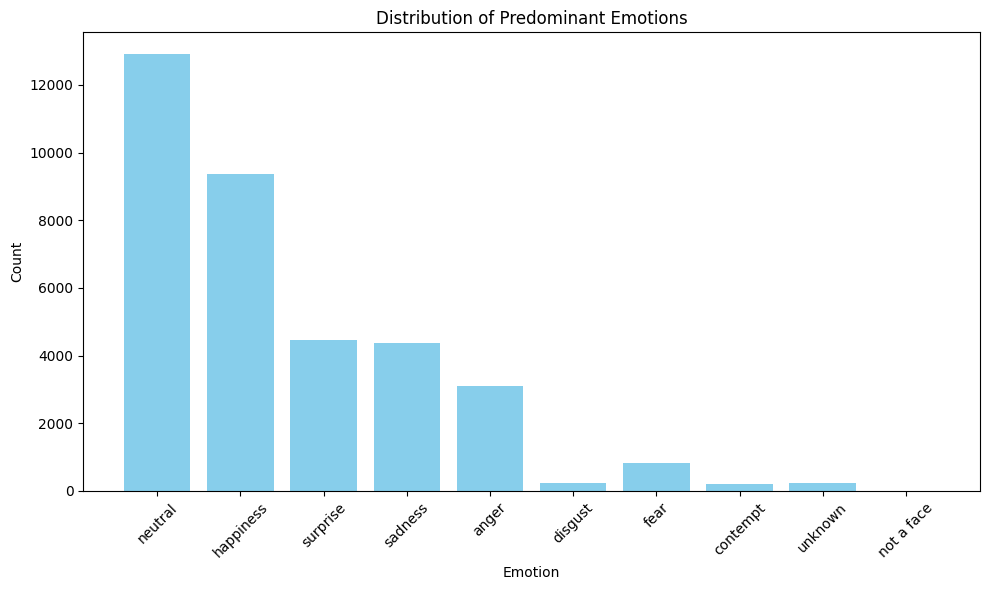

In [8]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "contempt",
    8: "unknown",
    9: "not a face"
}

# Count the number of occurrences of each emotion
unique_indices, counts = np.unique(emo_idx_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

plt.figure(figsize=(10, 6))
plt.bar(emotion_counts['Emotion'][:-1], emotion_counts['Count'][:-1], color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Predominant Emotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Remove the rows
relevant_df = emo_idx_df[~emo_idx_df['predominant_emotion_index'].isin([5, 6, 7, 8, 9])]
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34205 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Usage                      34205 non-null  object
 1   Image name                 34205 non-null  object
 2   predominant_emotion_index  34205 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


     Emotion  Count
0    neutral  12906
1  happiness   9355
2   surprise   4462
3    sadness   4371
4      anger   3111
5      Total  34205


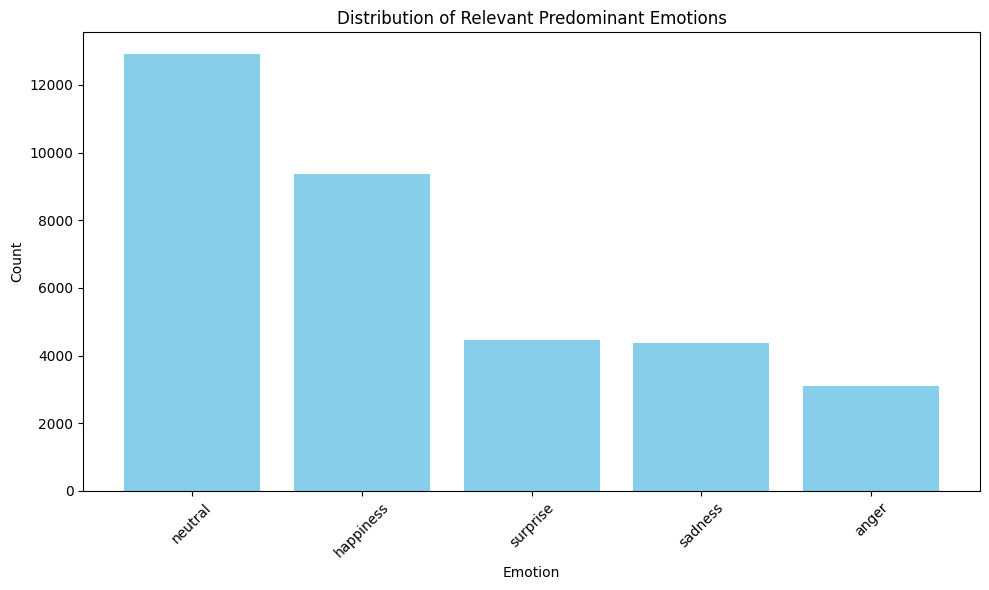

In [10]:
unique_indices, counts = np.unique(relevant_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

plt.figure(figsize=(10, 6))
plt.bar(emotion_counts['Emotion'][:-1], emotion_counts['Count'][:-1], color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Relevant Predominant Emotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Balance classes

In [11]:
# Define the function to filter the dataframe
def remove_random_rows(df, emotion_index, usage, num_rows_to_remove):
    subset = df[(df['predominant_emotion_index'] == emotion_index) & (df['Usage'] == usage)]
    remove_indices = subset.sample(n=num_rows_to_remove, random_state=42).index
    df_filtered = df.drop(remove_indices)
    return df_filtered

# Define the number of rows to remove for each condition
removals = {
    (0, 'Training'): 6300,
    (0, 'PublicTest'): 900,
    (0, 'PrivateTest'): 800,
    (1, 'Training'): 4100,
    (1, 'PublicTest'): 400,
    (1, 'PrivateTest'): 500
}

# Apply the removals
balanced_relevant_df = relevant_df.copy()
for (emotion_index, usage), num_rows in removals.items():
    balanced_relevant_df = remove_random_rows(balanced_relevant_df, emotion_index, usage, num_rows)

# Optionally, save the filtered dataframe to a new CSV file
balanced_relevant_df.to_csv('data/balanced_relevant_df.csv', index=False)
balanced_relevant_df['Usage'].value_counts()


Training       16981
PublicTest      2121
PrivateTest     2103
Name: Usage, dtype: int64

     Emotion  Count
0    neutral   4906
1  happiness   4355
2   surprise   4462
3    sadness   4371
4      anger   3111
5      Total  21205


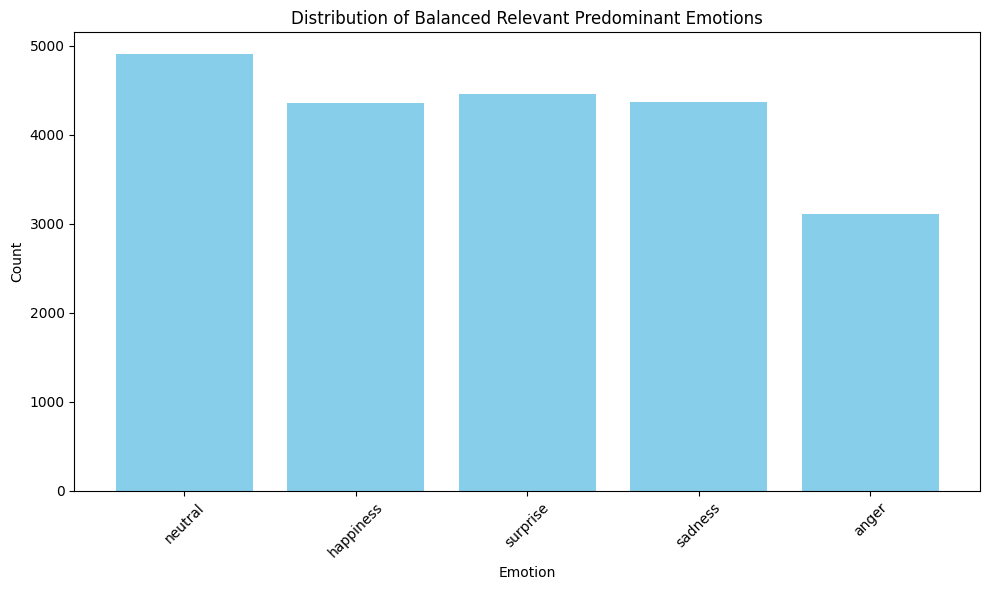

In [12]:
unique_indices, counts = np.unique(balanced_relevant_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

plt.figure(figsize=(10, 6))
plt.bar(emotion_counts['Emotion'][:-1], emotion_counts['Count'][:-1], color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Balanced Relevant Predominant Emotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Splitting data

### All data

In [13]:
# Creating separate DataFrame variables for each 'Usage' type
train_df = emo_idx_df[emo_idx_df['Usage'] == 'Training']
train_df.to_csv('data/train_df.csv', index=False)
valid_df = emo_idx_df[emo_idx_df['Usage'] == 'PublicTest']
valid_df.to_csv('data/valid_df.csv', index=False)
test_df = emo_idx_df[emo_idx_df['Usage'] == 'PrivateTest']
test_df.to_csv('data/test_df.csv', index=False)
train_df.shape, valid_df.shape, test_df.shape

((28561, 3), (3579, 3), (3574, 3))

In [14]:
unique_indices, counts = np.unique(train_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

       Emotion  Count
0      neutral  10309
1    happiness   7528
2     surprise   3562
3      sadness   3515
4        anger   2467
5      disgust    191
6         fear    652
7     contempt    165
8      unknown    170
9   not a face      2
10       Total  28561


In [15]:
unique_indices, counts = np.unique(valid_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

       Emotion  Count
0      neutral   1335
1    happiness    899
2     surprise    456
3      sadness    412
4        anger    319
5      disgust     34
6         fear     74
7     contempt     24
8      unknown     25
9   not a face      1
10       Total   3579


In [16]:
unique_indices, counts = np.unique(test_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

       Emotion  Count
0      neutral   1262
1    happiness    928
2     surprise    444
3      sadness    444
4        anger    325
5      disgust     23
6         fear     93
7     contempt     27
8      unknown     27
9   not a face      1
10       Total   3574


### Balanced relevant data

In [17]:
# Creating separate DataFrame variables for each 'Usage' type
relevant_train_df = balanced_relevant_df[balanced_relevant_df['Usage'] == 'Training']
relevant_train_df.to_csv('data/relevant_train_df.csv', index=False)
relevant_valid_df = balanced_relevant_df[balanced_relevant_df['Usage'] == 'PublicTest']
relevant_valid_df.to_csv('data/relevant_valid_df.csv', index=False)
relevant_test_df = balanced_relevant_df[balanced_relevant_df['Usage'] == 'PrivateTest']
relevant_test_df.to_csv('data/relevant_test_df.csv', index=False)
relevant_train_df.shape, relevant_valid_df.shape, relevant_test_df.shape

((16981, 3), (2121, 3), (2103, 3))

In [18]:
unique_indices, counts = np.unique(relevant_train_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

     Emotion  Count
0    neutral   4009
1  happiness   3428
2   surprise   3562
3    sadness   3515
4      anger   2467
5      Total  16981


In [19]:
unique_indices, counts = np.unique(relevant_valid_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

     Emotion  Count
0    neutral    435
1  happiness    499
2   surprise    456
3    sadness    412
4      anger    319
5      Total   2121


In [20]:
unique_indices, counts = np.unique(relevant_test_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

     Emotion  Count
0    neutral    462
1  happiness    428
2   surprise    444
3    sadness    444
4      anger    325
5      Total   2103


# Save resized and normalized images

In [21]:
# Function to save images resized and normalized, and label values to HDF5 
def save_images_to_hdf5(train_df, valid_df, test_df, base_path, hdf5_file):
    # Create a new HDF5 file or open an existing file
    with h5py.File(hdf5_file, 'w') as file:
        # Create datasets to store images, labels, and paths
        train_images = file.create_dataset('train_images', (train_df.shape[0], 224, 224, 3), dtype='float64')
        valid_images = file.create_dataset('valid_images', (valid_df.shape[0], 224, 224, 3), dtype='float64')
        test_images = file.create_dataset('test_images', (test_df.shape[0], 224, 224, 3), dtype='float64')

        train_labels = file.create_dataset('train_images_labels', (train_df.shape[0]), dtype='int32')
        valid_labels = file.create_dataset('valid_images_labels', (valid_df.shape[0]), dtype='int32')
        test_labels = file.create_dataset('test_images_labels', (test_df.shape[0]), dtype='int32')

        directory_map = {
            "Training": "FER2013Train",
            "PublicTest": "FER2013Valid",
            "PrivateTest": "FER2013Test"
        }

        # Counters for each dataset to track insertion positions
        train_idx, valid_idx, test_idx = 0, 0, 0
        
        # Store images in corresponding datasets
        for idx, row in train_df.iterrows():
            directory = directory_map.get(row['Usage'], None)
            if directory:
                image_path = os.path.join(base_path, directory, row['Image name'])
                label = row['predominant_emotion_index']

                # Load and process the image
                image = Image.open(image_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image) / 255.0
                image_array = np.stack((image_array,)*3, axis=-1)

                train_images[train_idx] = image_array
                train_labels[train_idx] = label
                train_idx += 1
        
        for idx, row in valid_df.iterrows():
            directory = directory_map.get(row['Usage'], None)
            if directory:
                image_path = os.path.join(base_path, directory, row['Image name'])
                label = row['predominant_emotion_index']

                # Load and process the image
                image = Image.open(image_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image) / 255.0
                image_array = np.stack((image_array,)*3, axis=-1)

                valid_images[valid_idx] = image_array
                valid_labels[valid_idx] = label
                valid_idx += 1

        for idx, row in test_df.iterrows():
            directory = directory_map.get(row['Usage'], None)
            if directory:
                image_path = os.path.join(base_path, directory, row['Image name'])
                label = row['predominant_emotion_index']

                # Load and process the image
                image = Image.open(image_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image) / 255.0
                image_array = np.stack((image_array,)*3, axis=-1)

                test_images[test_idx] = image_array
                test_labels[test_idx] = label
                test_idx += 1

# Function to inspect the contents of an HDF5 file
def inspect_hdf5_file(filepath):
    # Open the HDF5 file
    with h5py.File(filepath, 'r') as file:
        print("Datasets contained within the file:")
        for dataset_name in file:
            # Access the dataset
            dataset = file[dataset_name]
            # Print details about the dataset
            print(f"Dataset Info: {dataset_name}, {dataset.shape}, {dataset.dtype}")

In [22]:
# Base path for images
base_image_path = 'FERPlus-master/data'
hdf5_file = 'processed_images_all.hdf5'

# Save the images to HDF5 file
save_images_to_hdf5(train_df, valid_df, test_df, base_image_path, hdf5_file)
inspect_hdf5_file(hdf5_file)

Datasets contained within the file:
Dataset Info: test_images, (3574, 224, 224, 3), float64
Dataset Info: test_images_labels, (3574,), int32
Dataset Info: train_images, (28561, 224, 224, 3), float64
Dataset Info: train_images_labels, (28561,), int32
Dataset Info: valid_images, (3579, 224, 224, 3), float64
Dataset Info: valid_images_labels, (3579,), int32


In [23]:
# Base path for images
base_image_path = 'FERPlus-master/data'
hdf5_file = 'processed_images_balanced.hdf5'

# Save the images to HDF5 file
save_images_to_hdf5(relevant_train_df, relevant_valid_df, relevant_test_df, base_image_path, hdf5_file)
inspect_hdf5_file(hdf5_file)

Datasets contained within the file:
Dataset Info: test_images, (2103, 224, 224, 3), float64
Dataset Info: test_images_labels, (2103,), int32
Dataset Info: train_images, (16981, 224, 224, 3), float64
Dataset Info: train_images_labels, (16981,), int32
Dataset Info: valid_images, (2121, 224, 224, 3), float64
Dataset Info: valid_images_labels, (2121,), int32


# Transfer Learning (VGGFace, FaceNet)

In [ ]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Tests images shape:", test_images.shape, test_images.dtype)

print("Train labels shape:", train_labels.shape, train_labels.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)